# Final Project - Stock Price Prediction

## Table of Contents
1. [Purpose](#purpose)
2. [Read in libraries](#Read-in-libraries)
3. [Read in files](#read-in-files)
4. [Data Merging](#data-merging)
5. [Creating Metrics](#creating-metrics)
6. [Data Exploration](#data-exploration)
7. [Data Modeling](#data-modeling)
8. [Refitting the model](#refitting-the-model)

## Purpose 

* The purpose of this project is to develop a predictive model for forecasting the price of Halliburton Company (HAL)'s stock. Halliburton Company is an American multinational corporation and the world's second largest oil service company which is responsible for most of the world's largest fracking operations. The chosen approach involves utilizing the Random Forest algorithm along with additional predictors such as moving averages, RSI (Relative Strength Index), Bollinger Bands, and economic metrics such as interest rate, unemployment rate and crude oil price. By incorporating these predictors into the Random Forest model, the aim is to create a robust framework capable of generating accurate forecasts for HAL's stock prices.


### Method
* Predictors that will be used are:
    * simple moving average
    * exponential moving average
    * RSI (Relative strenght index)
    * Bollinger Bands
    * Interest rate
    * Unemployment rate
    * Crude Oil price
* Target variable
    * Closing price

## Read in libraries

In [46]:
import pandas as pd
import numpy as np 
import talib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

## Read in files
* The file was downloaded from Kaggle: 
    * https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data
        * The data contains full historical daily price and volume data for all US-based stocks and ETFs trading on the NYSE, NASDAQ, and NYSE MKT.
        * Data from 1981-12-31 to 2017-11-10
    * https://www.kaggle.com/datasets/varpit94/us-unemployment-rate-data 
        * Unemployment rate in US
        * Data from 1948-01-01
        * Data however, is available at a monthly level and would require a forward fill for rest of each months
    * https://www.kaggle.com/datasets/dennisholeski/historical-fed-funds
        * Interest rate
        * Includes daily historial federal(Fed) interest rates from 1954 to today
    * https://www.kaggle.com/datasets/mabusalah/brent-oil-prices
        * Crude oil price 
        * Contains daily Brent oil prices from 1987-05-17

* Based on the availability of the data, we will also filter the data to start from 1987-05-17


In [2]:
# reading in Halliburton 
halliburton = pd.read_csv('archive/Data/Stocks/hal.us.txt')
halliburton.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1981-12-31,6.3200,6.3564,6.2739,6.2739,291277,0
1,1982-01-04,6.2739,6.3564,6.2009,6.3200,289093,0
2,1982-01-05,6.1551,6.2926,6.0087,6.0545,484812,0
3,1982-01-06,5.9354,5.9908,5.8534,5.9814,786150,0
4,1982-01-07,5.9354,5.9908,5.8534,5.9354,369567,0


In [3]:
# read in unemployment rate
unemployment = pd.read_csv('archive/Data/unemployment_rate/US UR.csv')
unemployment.head()

,Yearmon,US UnemploymentRate
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5


In [4]:
# read in interest rate
fed_rate = pd.read_csv('archive/Data/fed_rate/fed-funds-rate-historical-chart.csv')
fed_rate.head()

,date,value
0,7/1/1954,1.13
1,7/2/1954,1.25
2,7/3/1954,1.25
3,7/4/1954,1.25
4,7/5/1954,0.88


In [5]:
# read in oil price
oil_price = pd.read_csv('archive/Data/oil_price/BrentOilPrices.csv')
oil_price.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


## Data Merging
* Need to merge the 4 datasets on date
* Need to reformat date to a consistent format (YYYY-MM-DD)

### Convert date time to YYYY-MM-DD

#### Unemployment

In [6]:
# Convert the column to datetime
unemployment['Yearmon'] = pd.to_datetime(unemployment['Yearmon'], format='%d-%m-%Y')

# Convert the datetime to 'yyyy-mm-dd' format
unemployment['Yearmon'] = unemployment['Yearmon'].dt.strftime('%Y-%m-%d')

unemployment.head()

,Yearmon,US UnemploymentRate
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


#### fed rate

In [7]:
# Convert the column to datetime
fed_rate['date'] = pd.to_datetime(fed_rate['date'])

# Convert the datetime to 'yyyy-mm-dd' format
fed_rate['date'] = fed_rate['date'].dt.strftime('%Y-%m-%d')

In [8]:
fed_rate = fed_rate.rename(columns={' value': 'fed_rate'})
fed_rate.head()

,date,fed_rate
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


#### oil price

In [9]:
# Convert the column to datetime
oil_price['Date'] = pd.to_datetime(oil_price['Date'])

# Convert the datetime to 'yyyy-mm-dd' format
oil_price['Date'] = oil_price['Date'].dt.strftime('%Y-%m-%d')

In [10]:
oil_price = oil_price.rename(columns={'Date':'date', 'Price':'oil_price'})
oil_price.head()

,date,oil_price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


### Merging on date

In [11]:
halliburton_all = pd.merge(
    halliburton, fed_rate, left_on="Date", right_on="date", how="left"
)

halliburton_all.drop(columns=['date'], inplace=True)
halliburton_all.head()


,Date,Open,High,Low,Close,Volume,OpenInt,fed_rate
0,1981-12-31,6.3200,6.3564,6.2739,6.2739,291277,0,13.13
1,1982-01-04,6.2739,6.3564,6.2009,6.3200,289093,0,13.31
2,1982-01-05,6.1551,6.2926,6.0087,6.0545,484812,0,12.90
3,1982-01-06,5.9354,5.9908,5.8534,5.9814,786150,0,12.12
4,1982-01-07,5.9354,5.9908,5.8534,5.9354,369567,0,12.37


In [12]:
halliburton_all = pd.merge(
    halliburton_all, unemployment, left_on="Date", right_on="Yearmon", how="left"
)

halliburton_all.drop(columns=['Yearmon'], inplace=True)
halliburton_all.head()

,Date,Open,High,Low,Close,Volume,OpenInt,fed_rate,US UnemploymentRate
0,1981-12-31,6.3200,6.3564,6.2739,6.2739,291277,0,13.13,NaN
1,1982-01-04,6.2739,6.3564,6.2009,6.3200,289093,0,13.31,NaN
2,1982-01-05,6.1551,6.2926,6.0087,6.0545,484812,0,12.90,NaN
3,1982-01-06,5.9354,5.9908,5.8534,5.9814,786150,0,12.12,NaN
4,1982-01-07,5.9354,5.9908,5.8534,5.9354,369567,0,12.37,NaN


In [13]:
halliburton_all = pd.merge(
    halliburton_all, oil_price, left_on="Date", right_on="date", how="left"
)

halliburton_all.drop(columns=['date'], inplace=True)
halliburton_all.head()

,Date,Open,High,Low,Close,Volume,OpenInt,fed_rate,US UnemploymentRate,oil_price
0,1981-12-31,6.3200,6.3564,6.2739,6.2739,291277,0,13.13,NaN,NaN
1,1982-01-04,6.2739,6.3564,6.2009,6.3200,289093,0,13.31,NaN,NaN
2,1982-01-05,6.1551,6.2926,6.0087,6.0545,484812,0,12.90,NaN,NaN
3,1982-01-06,5.9354,5.9908,5.8534,5.9814,786150,0,12.12,NaN,NaN
4,1982-01-07,5.9354,5.9908,5.8534,5.9354,369567,0,12.37,NaN,NaN


#### Forward filling
As mentioned above, Unemployment rate is a monthly data and only has data for the 1st of each month. 
Therefore we should forward fill the data for the rest of each month. 

In [14]:
halliburton_all['US UnemploymentRate'].ffill(inplace=True)

#### Filter date 1987-05-17
As mentioned above, the oil price data is only available starting from 1987-05-17.
Upon futher exploring data available from 1987-05-20

In [15]:
halliburton_all = halliburton_all[halliburton_all['Date'] > '1987-05-19']

#### Check for any missing data

In [16]:
# check for missing data
halliburton_all.isna().any()

# looks like oil_price column has some missing data

Date                   False
Open                   False
High                   False
Low                    False
Close                  False
Volume                 False
OpenInt                False
fed_rate               False
US UnemploymentRate    False
oil_price               True
dtype: bool

In [17]:
halliburton_all['oil_price'].isna().value_counts()
# 70 missing values, it's not too many we will drop them as long as they are not consecutive. 

False    7612
True       70
Name: oil_price, dtype: int64

In [18]:
missing_data = halliburton_all[halliburton_all['oil_price'].isna()]
missing_data.head()
# not consecutive. drop them 

,Date,Open,High,Low,Close,Volume,OpenInt,fed_rate,US UnemploymentRate,oil_price
1378,1987-06-15,5.8625,5.8808,5.7801,5.8261,392528,0,6.85,6.2,NaN
1521,1988-01-07,4.2801,4.6005,4.2619,4.5272,866841,0,6.91,5.7,NaN
1534,1988-01-26,4.2986,4.2986,4.2345,4.2801,197248,0,6.78,5.7,NaN
1581,1988-04-04,5.4783,5.5695,5.4327,5.5516,906203,0,6.71,5.7,NaN
1828,1989-03-27,5.0762,5.1218,5.0575,5.1034,418330,0,9.90,5.0,NaN


In [19]:
halliburton_final = halliburton_all[~(halliburton_all['oil_price'].isna())]
df = halliburton_final.copy() # just for convenience

## Creating metrics
* **simple moving average (sma)**
    * simple moving averages help smooth out price data and is useful for identifying trends and support/resistance levels in the stock prices
    * $\text{SMA}_{\text{N}} = \frac{\sum_{i=1}^{N} \text{Close}_i}{N}$

* **exponential moving average (ema)**
    * ema is different from sma in that it is more reactive to recent price changes and is more responsive to short-term price movements.
    * $\text{EMA}_{\text{span}} = \text{Close}_t \times \alpha + \text{EMA}_{\text{previous}} \times (1 - \alpha)$    
    Where $\alpha$ is calculated by: $\alpha = \frac{2}{\text{span} + 1}$


* **RSI (Relative strenght index)**
    * RSI helps identify potential reveral points in a stock's price trend. High RSI (>70) indicates overbought condition, while low RSI (<30) indicates oversold conditions
    * $\text{RSI} = 100 - \frac{100}{1 + \text{RS}}$
    Where *RS (relative strength)* is calculated by: $\text{RS} = \frac{\text{Average Gain}}{\text{Average Loss}}$

* **Bollinger Bands**
    * Bollinger bands help visualize volatility and similarly to RSI help identify potential price reversal. 
    * $\text{Middle Band} = \text{SMA}_{\text{window}}$
    * $\text{Upper Band} = \text{SMA}_{\text{window}} + (\text{Num\_std} \times \text{Standard Deviation})$
    * $\text{Lower Band} = \text{SMA}_{\text{window}} - (\text{Num\_std} \times \text{Standard Deviation})$


In [20]:
# Calculate Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Calculate Exponential Moving Average (EMA)
def calculate_ema(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return rolling_mean, upper_band, lower_band

# Example usage:
# Calculate SMA with a 10-day window
df['SMA_10'] = calculate_sma(df, window=10)

# Calculate EMA with a span of 10 days
df['EMA_10'] = calculate_ema(df, span=10)

# Calculate RSI with a 14-day window
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate Bollinger Bands with a 20-day window and 2 standard deviations
df['BB_Middle'], df['BB_Upper'], df['BB_Lower'] = calculate_bollinger_bands(df, window=20, num_std=2)

# Print the DataFrame with calculated indicators
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,fed_rate,US UnemploymentRate,oil_price,SMA_10,EMA_10,RSI_14,BB_Middle,BB_Upper,BB_Lower
1361,1987-05-20,5.6797,5.7437,5.5971,5.6612,705675,0,6.60,6.3,18.63,NaN,5.661200,NaN,NaN,NaN,NaN
1362,1987-05-21,5.7069,5.7069,5.6244,5.6612,641166,0,6.77,6.3,18.45,NaN,5.661200,NaN,NaN,NaN,NaN
1363,1987-05-22,5.6797,5.7069,5.5607,5.6244,571404,0,6.72,6.3,18.55,NaN,5.654509,NaN,NaN,NaN,NaN
1364,1987-05-26,5.6244,5.7069,5.5971,5.7069,652755,0,6.97,6.3,18.63,NaN,5.664035,NaN,NaN,NaN,NaN
1365,1987-05-27,5.7069,5.7985,5.7069,5.7069,641819,0,6.97,6.3,18.60,NaN,5.671828,NaN,NaN,NaN,NaN


As you can see b/c sma are calculated over 10, rsi over 15 and bb over 20 day window the first few rows will have missing data.
Therefore, if we remove the first 19 rows of data, we should have a useable dataset. 

In [21]:
# remove first 19 rows. 
df = df.iloc[19:]

## Data Exploration

In [22]:
# Display basic statistics of numerical columns
print(df.describe())

              Open         High          Low        Close        Volume  \
count  7593.000000  7593.000000  7593.000000  7593.000000  7.593000e+03   
mean     21.140974    21.455998    20.801696    21.129868  8.578775e+06   
std      14.838794    15.012746    14.646120    14.832110  8.670891e+06   
min       3.484400     3.676800     3.219400     3.502800  0.000000e+00   
25%       7.664000     7.755700     7.563500     7.664000  1.332624e+06   
50%      16.912000    17.376000    16.500000    16.903000  6.963148e+06   
75%      32.082000    32.556000    31.537000    32.082000  1.281618e+07   
max      70.250000    70.469000    69.428000    70.176000  1.683085e+08   

       OpenInt     fed_rate  US UnemploymentRate    oil_price       SMA_10  \
count   7593.0  7593.000000          7593.000000  7593.000000  7593.000000   
mean       0.0     3.410094             5.951666    45.272028    21.106887   
std        0.0     2.758468             1.485194    33.335264    14.807478   
min        0

### Stock Price and Volume

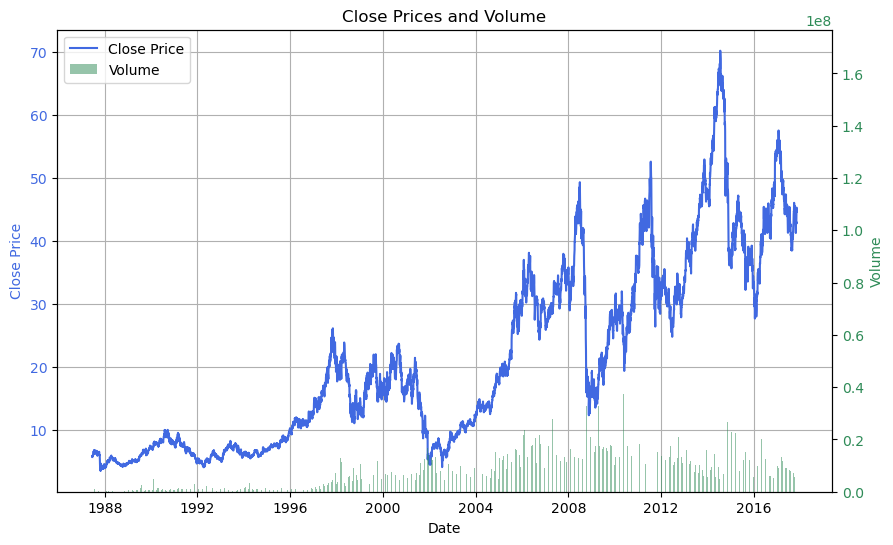

In [23]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot close prices as a line plot on the first y-axis
ax1.plot(df['Date'], df['Close'], color='royalblue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(True)

# Create a second y-axis for volume as a bar chart
ax2 = ax1.twinx()
ax2.bar(df['Date'], df['Volume'], color='seagreen', alpha=0.5, width=0.5, label='Volume')
ax2.set_ylabel('Volume', color='seagreen')
ax2.tick_params(axis='y', labelcolor='seagreen')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Close Prices and Volume')
plt.show()


### Oil Price and Stock Price
Based on the plot, clearly there is a relationship between oil price and the stock price

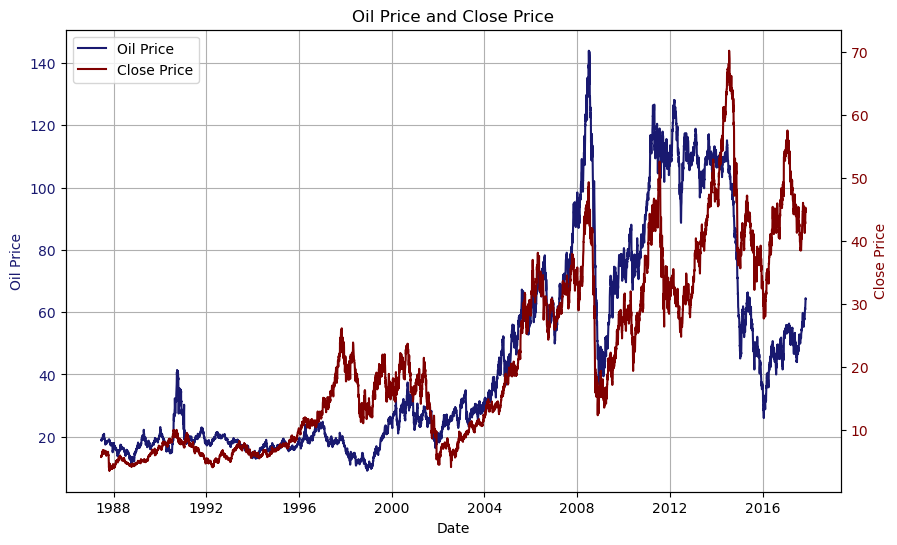

In [24]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot oil price as a line plot on the first y-axis
ax1.plot(df['Date'], df['oil_price'], color='midnightblue', label='Oil Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price', color='midnightblue')
ax1.tick_params(axis='y', labelcolor='midnightblue')
ax1.grid(True)

# Create a second y-axis for close price as a line plot
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Close'], color='maroon', label='Close Price')
ax2.set_ylabel('Close Price', color='maroon')
ax2.tick_params(axis='y', labelcolor='maroon')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Oil Price and Close Price')
plt.show()

### Interest rate and stock price

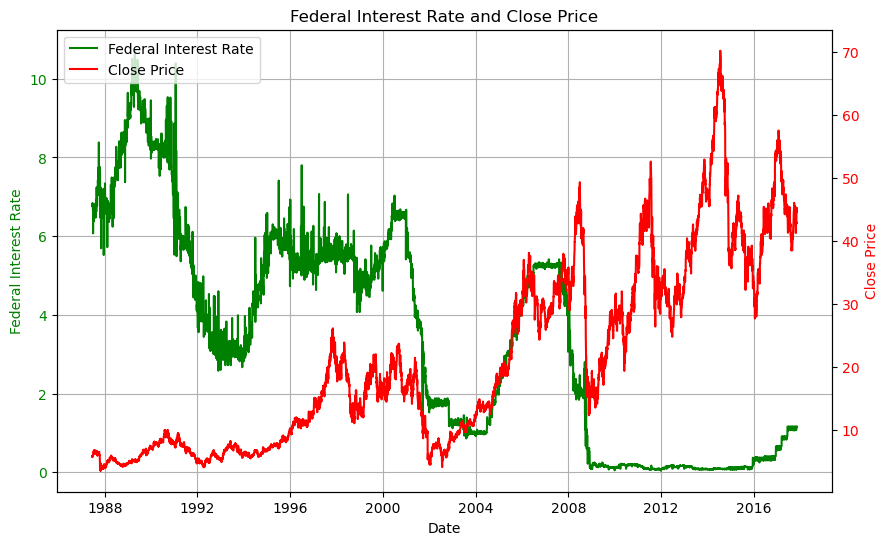

In [25]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot oil price as a line plot on the first y-axis
ax1.plot(df['Date'], df['fed_rate'], color='green', label='Federal Interest Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Federal Interest Rate', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Create a second y-axis for close price as a line plot
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Close'], color='red', label='Close Price')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Federal Interest Rate and Close Price')
plt.show()

### Unemployment Rate and Interest Rate
* Interestingly, when the federal rate is high, unemployment rate is low and viceversa. 
* It's called The Phillips curve, which suggests an inverse relationship between inflation and unemployment rates in an economy.
* There are multiple macro economic factors for this trend. For example, when there are more employed people, the demand for goods and services become high pushing inflation and to control inflation federal rate increase. 

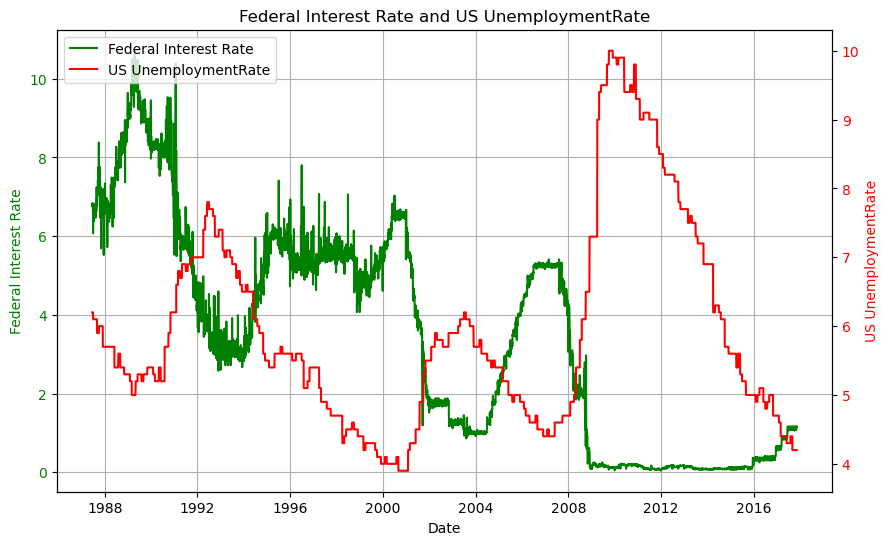

In [26]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot oil price as a line plot on the first y-axis
ax1.plot(df['Date'], df['fed_rate'], color='green', label='Federal Interest Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Federal Interest Rate', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Create a second y-axis for close price as a line plot
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['US UnemploymentRate'], color='red', label='US UnemploymentRate')
ax2.set_ylabel('US UnemploymentRate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Federal Interest Rate and US UnemploymentRate')
plt.show()

## Data Modeling
* As stated in the beginning, we will use Random Forest algorithm to predict stock prices. 
* Do note that the grid_search takes quite a bit of time
* We standardized the features to ensure that the scale of each feature does not impact the model

In [29]:
# Step 1: Prepare the data
X = df[['fed_rate', 'US UnemploymentRate', 'oil_price', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower']]
y = df['Close']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define the Random Forest model
rf_model = RandomForestRegressor()

# Step 5: Define the hyperparameters to search over using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Step 6: Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Step 7: Fit the model to the training data
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

# Step 8: Evaluate the model on the testing data
y_pred = best_rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

c:\Users\dshan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dshan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dshan\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\dshan\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\dshan\anaconda3\lib\site-packa

Mean Squared Error: 0.2132742996831308


### Model Evaluation
* Based on the metric and the plot, it seems like the model has overfitted. 

In [47]:
# Step 1: Evaluate the model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Evaluation Metrics:
Mean Squared Error (MSE): 0.2132742996831308
Root Mean Squared Error (RMSE): 0.46181630512913985
R-squared (R2) Score: 0.9990125384936281


#### Plotting predicted vs actual

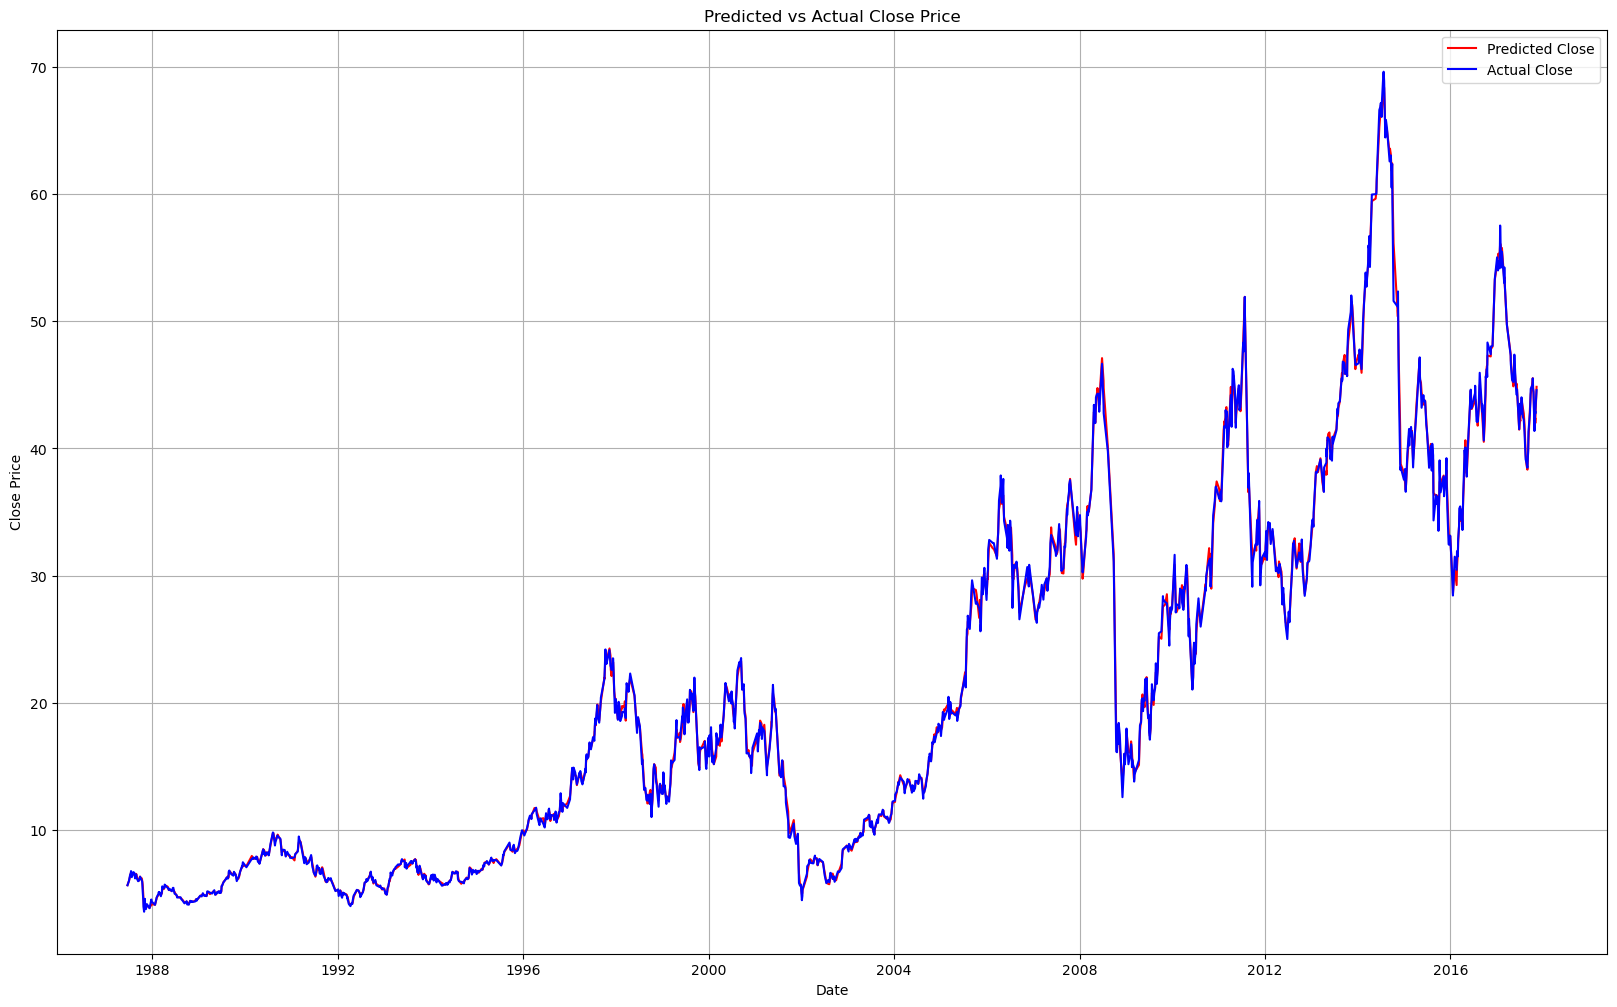

In [36]:
X_test['Date'] = df.loc[X_test.index, 'Date']

# Make predictions on the testing data
y_pred_test = best_rf_model.predict(X_test_scaled)

# Create a DataFrame with Date, Predicted_Close, and Actual_Close
results_df = pd.DataFrame({'Date': X_test['Date'], 'Predicted_Close': y_pred_test, 'Actual_Close': y_test})

# Sort DataFrame by Date
results_df = results_df.sort_values(by='Date')

# Plot the predicted and actual close prices
plt.figure(figsize=(20, 12))
plt.plot(results_df['Date'], results_df['Predicted_Close'], color='red', label='Predicted Close')
plt.plot(results_df['Date'], results_df['Actual_Close'], color='blue', label='Actual Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted vs Actual Close Price')
plt.legend()
plt.grid(True)
plt.show()

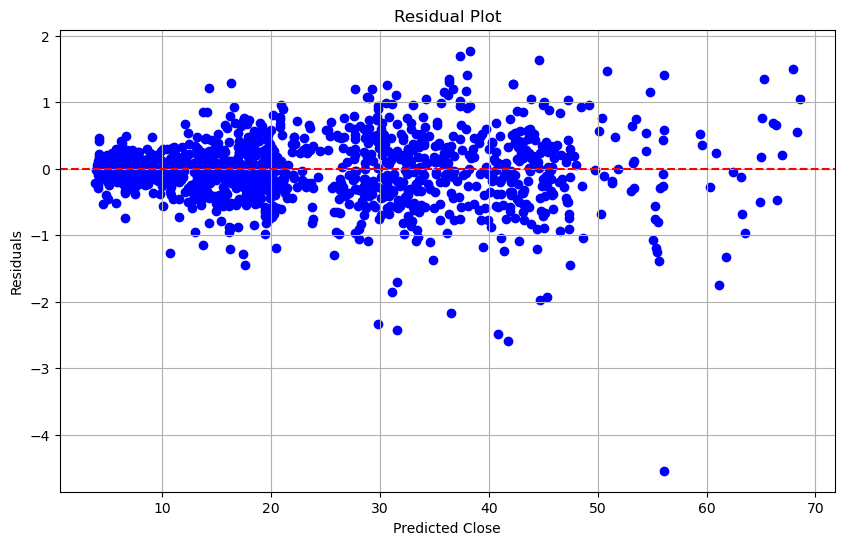

In [34]:
# Residual Plot
residuals = results_df['Actual_Close'] - results_df['Predicted_Close']
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Predicted_Close'], residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Close')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

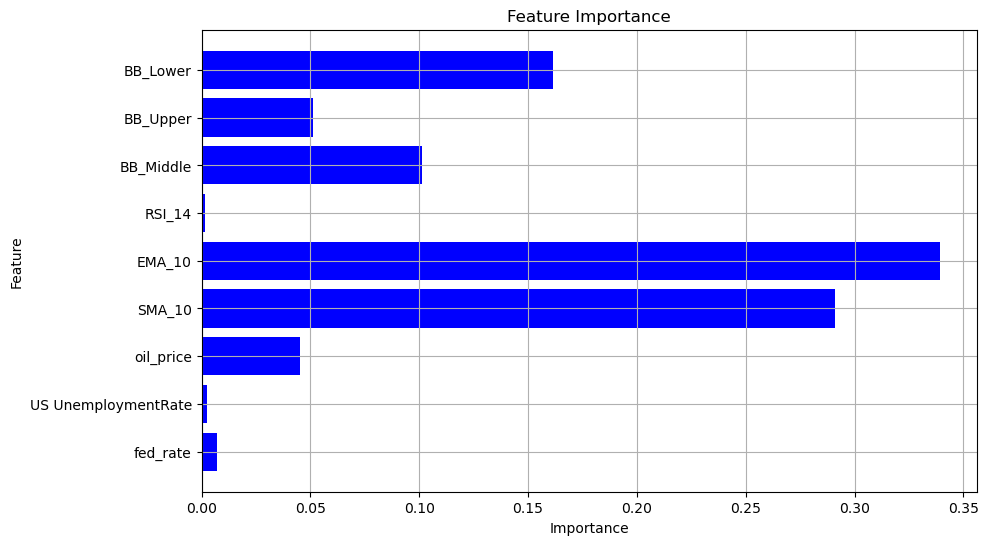

In [38]:
# Feature Importance Plot
feature_importance = best_rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.grid(True)
plt.show()

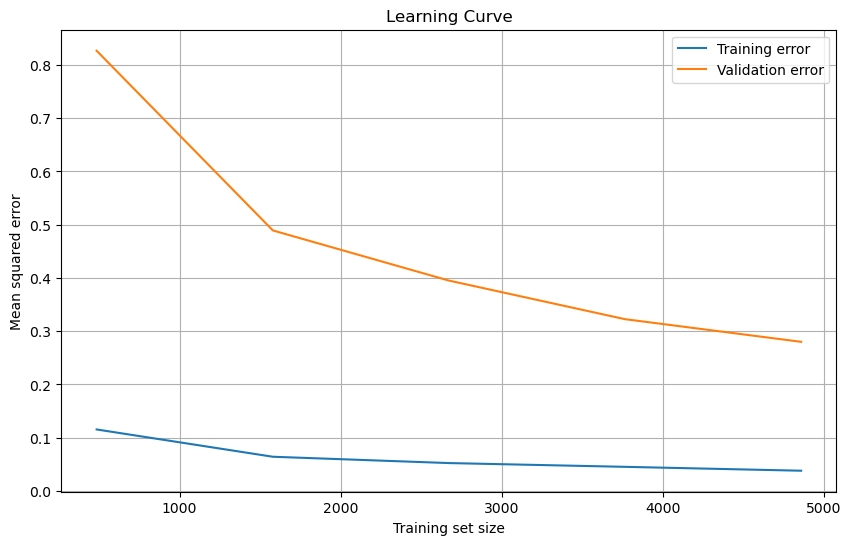

In [39]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Step 3: Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

In [49]:
# Check the number of trees in the forest
n_estimators = best_rf_model.n_estimators

# Check the maximum depth of trees in the forest
max_depth = best_rf_model.max_depth

# Check the minimum number of samples required to be at a leaf node
min_samples_leaf = best_rf_model.min_samples_leaf

print("Number of Trees:", n_estimators)
print("Maximum Depth of Trees:", max_depth)
print("Minimum Samples per Leaf:", min_samples_leaf)


Number of Trees: 200
Maximum Depth of Trees: 20
Minimum Samples per Leaf: 1


## Refitting the model

In [63]:
# Define the hyperparameters for the Random Forest model
n_estimators = 100  # Reduced number of trees
max_depth = 10  # Reduced maximum depth of trees
min_samples_split = 25
min_samples_leaf = 50  # Increased minimum samples per leaf

# Create the Random Forest model with specified hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42  # For reproducibility
)

# Fit the model with the training data
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model on the testing data
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6029817219470882


In [64]:
# Step 1: Evaluate the model on the test set
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Evaluation Metrics:
Mean Squared Error (MSE): 0.6029817219470882
Root Mean Squared Error (RMSE): 0.7765189771970085
R-squared (R2) Score: 0.9972081903897789


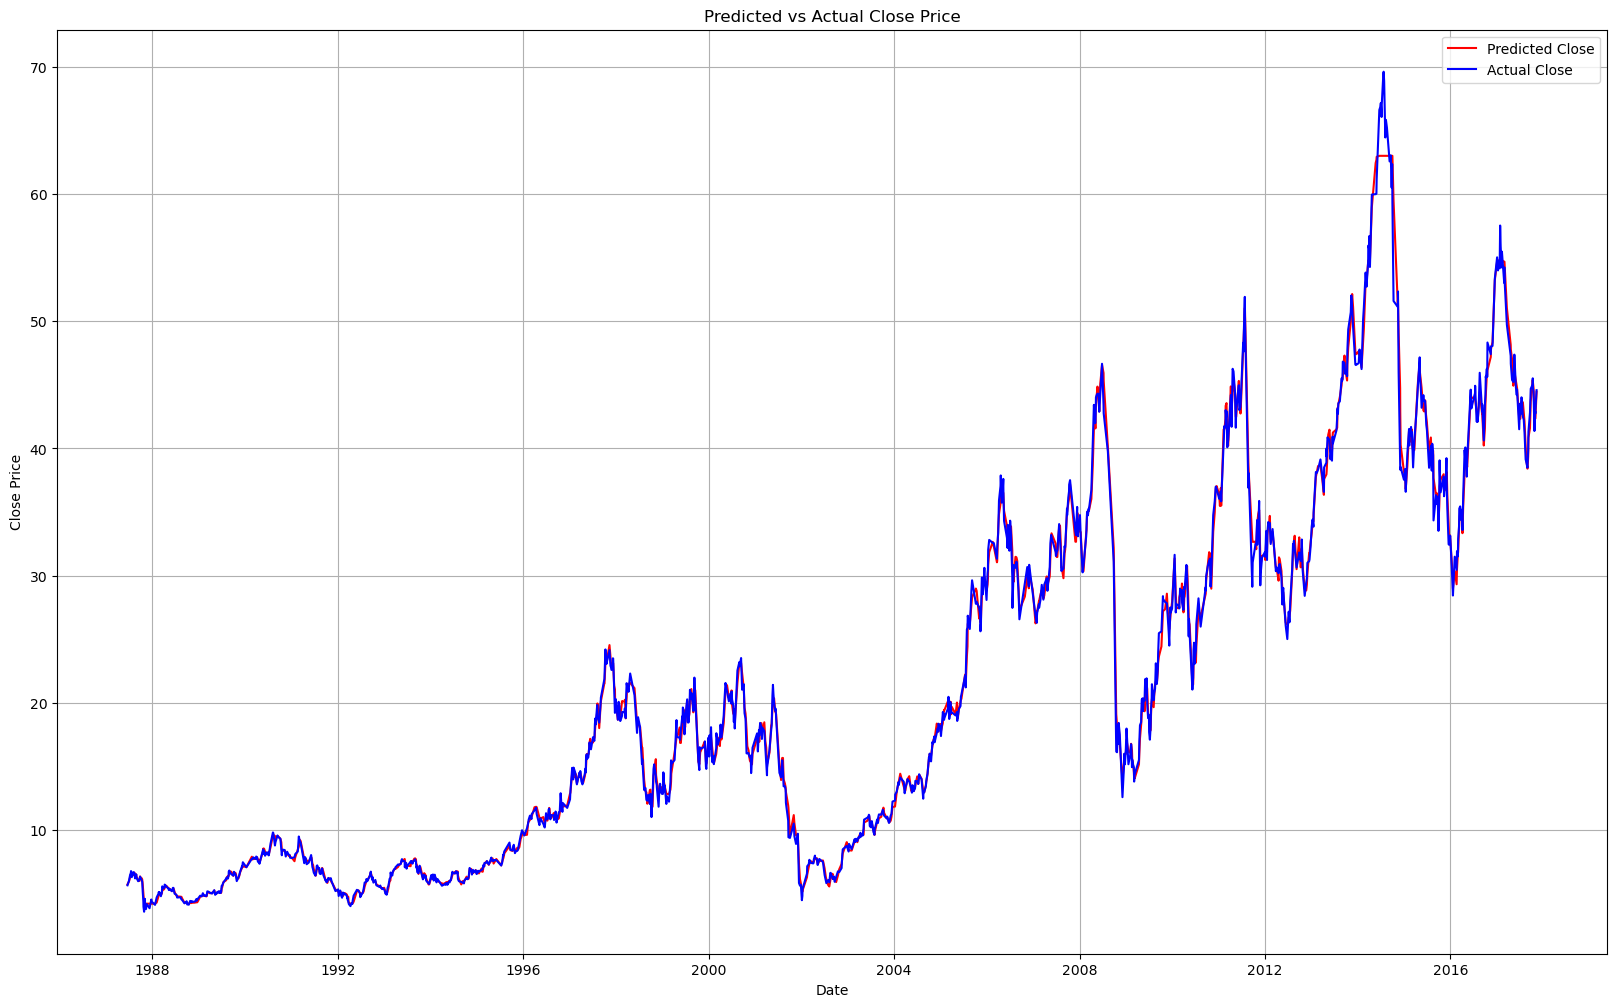

In [65]:
X_test['Date'] = df.loc[X_test.index, 'Date']

# Make predictions on the testing data
y_pred_test = rf_model.predict(X_test_scaled)

# Create a DataFrame with Date, Predicted_Close, and Actual_Close
results_df = pd.DataFrame({'Date': X_test['Date'], 'Predicted_Close': y_pred_test, 'Actual_Close': y_test})

# Sort DataFrame by Date
results_df = results_df.sort_values(by='Date')

# Plot the predicted and actual close prices
plt.figure(figsize=(20, 12))
plt.plot(results_df['Date'], results_df['Predicted_Close'], color='red', label='Predicted Close')
plt.plot(results_df['Date'], results_df['Actual_Close'], color='blue', label='Actual Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted vs Actual Close Price')
plt.legend()
plt.grid(True)
plt.show()